# customized AI in research and diagnostics using xnat and python 

this tutorial teaches basic operations: 

e.g.
   - up-/downloading data from xnat
   - image-processing (image registration, segmentation, classification)
   
by the end of this tutorial you will know how to: 
   - load specific scans or project 
   - establish a segmentation pipeline 
   - include pretrained models and predict on real data 
    
  
a little python experience is desirable but not mandatory 

M. Moeskes, R. Lützkendorf, IBMI 2022

## 1. prerequisites: setting up the environment

install necessary libraries to our working directory via terminal commands

In [ ]:
!pip install xnat
!pip install pydicom 
!pip install SimpleITK as sitk 

let's import the libraries

In [12]:
import os 
import xnat
import SimpleITK as sitk 
import matplotlib.pyplot as plt
import numpy as np 
import zipfile # for vceatring zips 
from pydicom import dcmread # reda dcm image 
import pandas as pd #data processing

## 2. getting to work 

## 2.1 connect to xnat and choose a project

In [43]:
# connect to xnat
session = xnat.connect('http://149.203.111.199',user='admin',password='admin')

# define target directory for download
root = 'XNAT_TEST'
project_dir = 'GANZES_PROJEKT_TEST'
# f strings help avoiding .format() function call 
target_dir = f'{root}/{project_dir}'
# check if dirs exist 
if os.path.exists(root):
    print(root, 'exists')
else:
    os.mkdir(root)

if os.path.exists(target_dir):
    print(target_dir, 'exists')
else:
    os.mkdir(target_dir)
# save all projects in a variable 
projects = session.projects
# choose project 
project = session.projects['Chili_clean']

download = True

XNAT_TEST exists
XNAT_TEST/GANZES_PROJEKT_TEST exists


## 2.2 save preassumely commonly used blocks of code as functions

In [44]:
# in order to work on different levels of the file-hierarchy, basic import functions are defined
# theoretically custom data-filters could thus be implemented in future 
def get_projects(session):
    # returns a list of all projects
    return session.projects

def get_subjects(project):
    # returns a list of all subjects of a project
    return [project.subjects[sub] for sub in project.subjects]
           
def get_experiments(project):
    # returns list of all experiments of a project 
    exp = []
    
    for sub in project.subjects:
        for i in range(len(project.subjects[sub].experiments)):
            current_scan = project.subjects[sub].experiments[i]
            exp.append(current_scan)
    return exp

def get_scans(project, exp):
    # returns list of all scans of a project 
    scans = []
    
    for sub in project.subjects:
        for i in range(len(project.subjects[sub].experiments)):
            
            if  str(exp[0]) ==  str(project.subjects[sub].experiments[i]):
                for j in range(len(project.subjects[sub].experiments[i].scans)):
                
                    current_scan = project.subjects[sub].experiments[i].scans[j]
                    scans.append(current_scan)

    return scans

# function for downloading a whole project 
def download_project(project):
    
    # query REST tree, save each scan acoording to its index in zip
    # switching from string indexing to integers in 2nd loop because 
    # 1) xnats pyAPI does not use same python objects among different levels 
    # 2) file names may be inconsistent, saving them as numbers with leading zeros makes batch processing easy 
    for sub in project.subjects:
        for i in range(len(project.subjects[sub].experiments)):
            for j in range(len(project.subjects[sub].experiments[i].scans)):
            
                current_scan = project.subjects[sub].experiments[i].scans[j]
                target_dir_zip = f'{target_dir}/{i:02d}+{j:02d}.zip'
                
                current_scan.download(target_dir_zip)
                # extract zip
                with zipfile.ZipFile(target_dir_zip, 'r') as zip_ref:
                     zip_ref.extractall(f'{target_dir}/{i:02d}+{j:02d}')
                os.remove(target_dir_zip)   
#print(get_scans(project))

def download_scan(project,scan, single, out_gui):
    
    single = 1 #if 1 neglect similar scans
    sscan = str(scan)
    sout_gui = str(out_gui)
    
    for sub in project.subjects:
        for i in range(len(project.subjects[sub].experiments)):
            for j in range(len(project.subjects[sub].experiments[i].scans)):
            
                current_scan = project.subjects[sub].experiments[i].scans[j]
                scurrent_scan = str(current_scan)
                # process strings
                sscan = sscan.replace('[',' ').replace(']', ' ').strip()
                sout_gui = sout_gui.replace('[',' ').replace(']',' ').replace("'",' ').strip()
                
         
                if not single and sscan == scurrent_scan: #applies if you want similar series e.g. all x rays 
                    
                    target_dir_zip = f'{target_dir}/{i:02d}+{j:02d}.zip'
                    current_scan.download(target_dir_zip)
                    
                    with zipfile.ZipFile(target_dir_zip, 'r') as zip_ref:
                             zip_ref.extractall(f'{target_dir}/{i:02d}+{j:02d}')
                   
                
                if sscan == scurrent_scan and sout_gui ==  str(project.subjects[sub].experiments[i]):
                        target_dir_zip = f'{target_dir}/{i:02d}+{j:02d}.zip'
                        current_scan.download(target_dir_zip)
                    
                        with zipfile.ZipFile(target_dir_zip, 'r') as zip_ref:
                             zip_ref.extractall(f'{target_dir}/{i:02d}+{j:02d}')
                        os.remove(target_dir_zip)
                        
                        return f'{target_dir}/{i:02d}+{j:02d}', project.subjects[sub]
                        
 

### lets test a couple of functions


In [47]:
#print(get_experiments(project))
download_project(project)

785.2 KiB |#                                                      | 126.5 MiB/s
 16.2 MiB |#                                                      | 386.1 MiB/s
 95.4 KiB |#                                                      |  85.4 MiB/s
  6.5 MiB |#                                                      | 165.1 MiB/s
 30.7 MiB |      #                                                |  50.2 MiB/s
  2.8 MiB |#                                                      | 148.3 MiB/s
  3.6 MiB |#                                                      | 163.2 MiB/s
  3.3 MiB |#                                                      | 165.8 MiB/s
785.3 KiB |#                                                      | 212.3 MiB/s
  1.5 MiB |#                                                      | 140.9 MiB/s
  3.3 MiB |#                                                      | 152.7 MiB/s
  3.3 MiB |#                                                      | 167.8 MiB/s
 13.1 MiB |#                            

 31.2 MiB |  #                                                    | 133.8 MiB/s
195.6 MiB |              #                                        | 130.8 MiB/s
 37.7 MiB |  #                                                    | 143.0 MiB/s
195.6 MiB |             #                                         | 144.4 MiB/s
 86.2 MiB |      #                                                | 132.5 MiB/s
 55.2 MiB |   #                                                   | 140.7 MiB/s
 63.0 MiB |    #                                                  | 147.6 MiB/s
100.4 MiB |       #                                               | 141.5 MiB/s
515.3 KiB |#                                                      | 331.7 MiB/s
  2.8 MiB |#                                                      | 138.3 MiB/s
  3.2 MiB |#                                                      | 130.5 MiB/s
  3.0 MiB |#                                                      | 158.2 MiB/s
785.0 KiB |#                            

 54.2 MiB |   #                                                   | 143.9 MiB/s
513.5 KiB |#                                                      |  72.6 MiB/s
 11.2 MiB |#                                                      | 163.2 MiB/s
 75.5 MiB |     #                                                 | 128.9 MiB/s
 33.7 MiB |  #                                                    | 128.8 MiB/s
 36.2 MiB |  #                                                    | 129.4 MiB/s
 16.6 MiB | #                                                     | 119.8 MiB/s
  2.1 MiB |#                                                      | 147.9 MiB/s
547.4 KiB |#                                                      | 265.0 MiB/s
  1.6 MiB |#                                                      | 182.1 MiB/s
 22.9 MiB | #                                                     | 163.5 MiB/s
192.4 KiB |#                                                      | 138.8 MiB/s
229.2 MiB |               #             

 13.4 MiB |#                                                      | 181.9 MiB/s
  6.2 MiB |#                                                      | 163.3 MiB/s
  4.6 MiB |#                                                      | 195.3 MiB/s
616.7 KiB |#                                                      | 141.8 MiB/s
  1.0 MiB |#                                                      | 161.9 MiB/s
  5.0 MiB |#                                                      | 150.6 MiB/s
  5.2 MiB |#                                                      | 188.9 MiB/s
  8.2 MiB |#                                                      | 174.7 MiB/s
374.4 KiB |#                                                      | 249.4 MiB/s
  5.9 MiB |#                                                      | 169.4 MiB/s
  2.0 MiB |#                                                      | 341.3 MiB/s
  1.0 MiB |#                                                      | 229.9 MiB/s
 20.1 MiB | #                           

### now choose an x ray scan from a simple gui 

In [67]:
!pip install easygui

     |████████████████████████████████| 92 kB 1.2 MB/s eta 0:00:011


In [48]:
from easygui import * 
# message to be displayed
text = "please select x-ray/cr experiment from the list given below"
# window title
title = "IBMI-XNAT"
# item choices
choices = get_experiments(project)
# creating a multi choice box
output = multchoicebox(text, title, choices)
# title for the message box
title = "IBMI-XNAT notification"
# message
message = "selected experiments : " + str(output)
# creating a message box
msg = msgbox(message, title)

In [5]:
print(output)

['<CrSessionData MarkoMarkovic_CR_1 (XNAT2_E00011)>']


In [49]:
text = "select a x-ray/cr scan from the list given below. if same scan appears twice no other scan is available"
# window title
title = "IBMI-XNAT"
# item choices
choices = get_scans(project, output)
# creating a multi choice box
if len(choices) < 2:
    choices = [choices,choices]
    output2 = choicebox(text, title, choices)
else:
    output2 = multchoicebox(text, title, choices)
 
# title for the message box
title = "IBMI-XNAT notification"
# message
message = "selected scan : " + str(output2)
# creating a message box
msg = msgbox(message, title)

In [50]:
path_to_im, subject = download_scan(project, output2, 1, output)

 16.2 MiB |#                                                      | 353.8 MiB/s


In [51]:
#lets get the x ray
file_list = []

for path, dirs, files in os.walk(path_to_im):
    for file in files:
        file_list.append(os.path.join(path, file))

XNAT_TEST/GANZES_PROJEKT_TEST/01+00/MarkoMarkovic_CR_1/scans/1-Exspiration_pa/resources/DICOM/files/1.2.276.0.24.276.157513124.4.0.1-1-1-16f53r.dcm


True

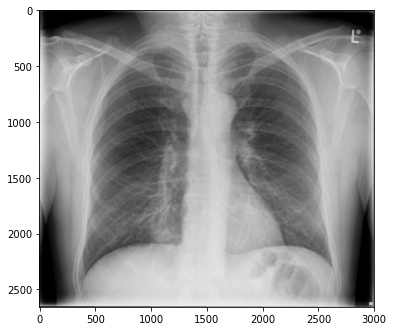

In [75]:
# händisch unser pfad 
path = file_list[0]
print(path)
ds = dcmread(path)
im = ds.pixel_array
# visualize with matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(im, cmap = 'gray')

cv2.imwrite('image_to_predict.jpg',im)

## nice2have: segmentation via itk-snap 

In [54]:
import pydicom
from pydicom.dataset import Dataset
from pydicom.uid import generate_uid
import cv2
os.system("itksnap -g {f}".format(f=path))

path_seg = 'XNAT_TEST/GANZES_PROJEKT_TEST/01+00/segmentation.nii.gz'
seg = sitk.GetArrayFromImage(sitk.ReadImage(path_seg))

seg = np.squeeze(seg)
seg = cv2.resize(seg,(150,150))
im = cv2.resize(im,(150,150))
#ds = Dataset()

ds.PixelData = seg.tobytes()
# update the information regarding the shape of the data array
ds.Rows, ds.Columns = seg.shape

ds.UID = generate_uid()

#ds.pixel_array = seg
pydicom.filewriter.write_file('XNAT_TEST/GANZES_PROJEKT_TEST/01+00/segmentation.dcm', ds)

ds.PixelData = im.tobytes()
# update the information regarding the shape of the data array
ds.Rows, ds.Columns = im.shape

ds.UID = generate_uid()

#ds.pixel_array = seg
pydicom.filewriter.write_file('XNAT_TEST/GANZES_PROJEKT_TEST/01+00/image_resized.dcm', ds)

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: sCAL: invalid unit
Return code : 0


## now create a zip file for uploading the segmentation

### upload resized  chest x ray  

In [55]:
import shutil
#out_path1=shutil.make_archive('XNAT_TEST/GANZES_PROJEKT_TEST/01+00/segmentation.dcm', 'zip', 'XNAT_TEST/GANZES_PROJEKT_TEST/01+00')
#print(out_path1)
out_path2=shutil.make_archive('XNAT_TEST/GANZES_PROJEKT_TEST/01+00/image_resized.dcm', 'zip', 'XNAT_TEST/GANZES_PROJEKT_TEST/01+00')
print(out_path2)

/home/miracum/XNAT_TEST/GANZES_PROJEKT_TEST/01+00/image_resized.dcm.zip


### upload

In [56]:
session.services.import_(out_path2, project=project, subject='test002', destination='/prearchive')

#session.disconnect()

<PrearchiveSession chili_clean/20221017_093224059/1840621>

(150, 150)

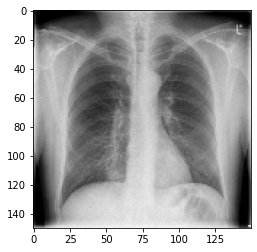

In [61]:
im = dcmread('Downloads/image_resized.dcm')
plt.imshow(im.pixel_array,cmap='gray' )
np.shape(im.pixel_array)

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam

2022-10-17 11:48:07.144402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


##  load pretrained chest x ray classification model

In [64]:
trained_model = tf.keras.models.load_model('model_pneumonia_det/cnn_2d_binary') #or cw binary 
# Check its architecture
#trained_model.summary()

2022-10-17 11:48:18.141477: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-17 11:48:18.142186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-17 11:48:18.171039: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-17 11:48:18.171055: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DIZ-UMMD-B177): /proc/driver/nvidia/version does not exist
2022-10-17 11:48:18.171511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flag

In [65]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import cv2

#### since we trained our model on mini-batches, our input is a tensor of shape [batch_size, image_width, #### image_height, number_of_channels]; hence we resize and expand dims that a 2d-image is treated as tensor

In [88]:
file = 'chest_xray_xnat.jpg'
#file = 'chest_child_healthy.jpeg'
#file = 'xray_child_pneumonia.jpg'
#file = 'xray_radioapaedia.jpeg'
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

image = resize(image, (150, 150,1))
image_pred = np.expand_dims(image,axis=0)

result = trained_model.predict_classes(image_pred) 
print(result)

[[0]]
